In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal
from collections import namedtuple
import matplotlib.pyplot as plt
import nbimporter
from DistanceCoefficientDegradation import get_distance_coefficient_degradation
from DistanceCoefficientDegradation import distance_rbc

Importing Jupyter notebook from DistanceCoefficientDegradation.ipynb


# 当該住戸の外皮の部位の面積等を用いずに外皮性能を評価する方法

## はじめに

本計算方法は、省エネ基準の「当該住戸の外皮の部位の面積等を用いずに外皮性能を評価する方法」に、以下のアレンジを加えた評価となっています。

- 省エネ基準では主開口部の方位は南西に固定されているところ、本計算方法では8方位の中から選択可能
- 省エネ基準では、窓のU値・η値(暖房期・冷房期）について1種類のみ指定可能であるところ、本計算方法では主開口とそのほかの開口に分けて入力可能
- 区域建蔽率から求まる方位係数の低減を考慮

< 以下はU値計算のノートに記述 >
- 屋根／天井、外壁、床について省エネ基準でのU値入力はそのままに、R値と断熱材厚さからU値を計算できる手法を追加
- ドアについて省エネ基準でのU値入力はそのままに、枠の種類・戸の種類・ガラスの有無と有りの場合のUg値からU値を計算できる手法を追加
- 窓について省エネ基準でのU値入力はそのままに、建具の種類、Ug値からU値を計算できる手法を追加
- 土間床周辺部について省エネ基準でのψ値入力はそのままに、断熱材の厚さや長さ、施工位置などからψを計算する手法を追加

## 一次エネ計算方法で使用する関数について

本仕様書は将来的な拡張性を考えた計算方法である、  
U_A, eta_A_H, eta_A_C について記してあるが、  
当面使用する関数は、  
U_A_2, eta_A_H_2, eta_A_C_2 である。  
U_A_2, eta_A_H_2, eta_A_C_2 の定義等は最後に記す。

## 型

direction 型：主開口方位から時計回りに0度、90度、180度、270度、上面、下面  
direction_H 型：direction 型のうち、上面・下面を除いたもの ( H = Horizontal )  
direction_base 型：direction_H 型に加えて、内側(Inside)　を加えたもの  
orientation 型：南・南西・西・北西・北・北東・東・南東の8方位に加え、上面、下面を加えたもの

In [2]:
class direction:
    def __init__( self, ES0, ES90, ES180, ES270, top, bottom ):
        self.ES0    = ES0
        self.ES90   = ES90
        self.ES180  = ES180
        self.ES270  = ES270
        self.top    = top
        self.bottom = bottom

In [3]:
class direction_H:
    def __init__( self, ES0, ES90, ES180, ES270 ):
        self.ES0   = ES0
        self.ES90  = ES90
        self.ES180 = ES180
        self.ES270 = ES270

In [4]:
class direction_base:
    def __init__( self, ES0, ES90, ES180, ES270, IS ):
        self.ES0   = ES0
        self.ES90  = ES90
        self.ES180 = ES180
        self.ES270 = ES270
        self.IS    = IS

In [5]:
class orientation:
    def __init__( self, S, SW, W, NW, N, NE, E, SE, top, bottom ):
        self.S      = S
        self.SW     = SW
        self.W      = W
        self.NW     = NW
        self.N      = N
        self.NE     = NE
        self.E      = E
        self.SE     = SE
        self.top    = top
        self.bottom = bottom

### orientation型からdirection型への変更

主開口方位を指定することで、orientation型(8方位＋上・下)からdirection型(4方向＋上・下)に変換する。

In [6]:
def orientation_to_direction( typeO, main_direction ):
    # typeO orientation 型
    # main_direction: 主たる方位　( 'S', 'SW', 'W', 'NW', 'N', 'NE', 'E', 'SE' )
    # direction_H 型: 主たる方位から、0,90,180,270 度の値
    if   ( main_direction == 'S' ): return direction ( typeO.S,  typeO.W,  typeO.N,  typeO.E,  typeO.top, typeO.bottom )
    elif ( main_direction == 'SW'): return direction ( typeO.SW, typeO.NW, typeO.NE, typeO.SE, typeO.top, typeO.bottom )
    elif ( main_direction == 'W' ): return direction ( typeO.W,  typeO.N,  typeO.E,  typeO.S,  typeO.top, typeO.bottom  )
    elif ( main_direction == 'NW'): return direction ( typeO.NW, typeO.NE, typeO.SE, typeO.SW, typeO.top, typeO.bottom )
    elif ( main_direction == 'N' ): return direction ( typeO.N,  typeO.E,  typeO.S,  typeO.W,  typeO.top, typeO.bottom  )
    elif ( main_direction == 'NE'): return direction ( typeO.NE, typeO.SE, typeO.SW, typeO.NW, typeO.top, typeO.bottom )
    elif ( main_direction == 'E' ): return direction ( typeO.E,  typeO.S,  typeO.W,  typeO.N,  typeO.top, typeO.bottom  )
    elif ( main_direction == 'SE'): return direction ( typeO.SE, typeO.SW, typeO.NW, typeO.NE, typeO.top, typeO.bottom )
    else: raise( 'Wrong Direction Name' )

## デフォルトで設定された面積

デフォルトで設定される面積は、省エネ基準の仕様書の第3章第2節の表3で指定される。  
ただし、ここで定義する方法は主開口方位を任意に設定できる（省エネ基準では主開口方位が南西に固定されている。）ため、方位について以下のように読み替える。  
※ES:Envelope Surface 主開口方位から時計回りに0度・90度・180度・270度  
南西→ES0  
北西→ES90  
北東→ES180  
南東→ES270  

In [7]:
class Area_and_Length:
    
    def __init__(self, house):
        # house には 'floor_ins' 又は 'base_ins' を指定する。
        
        if house == 'floor_ins':
            house_num = 0
        elif house == 'base_ins':
            house_num = 1
        else:
            raise("Wrong character for house type")

        self.env    = [ 266.10, 275.69 ][house_num]                                  # 外皮の部位の面積の合計(m2)
        self.A      = 90.0                                                           # 延べ床面積の合計(m2)
        self.roof   = 50.85                                                          # 屋根又は天井の面積(m2)
        self.wall   = direction_H( 30.47, 22.37, 47.92, 22.28 )                      # 壁の面積(m2) (4方位)
        self.door   = direction_H( 0.00, 1.89, 1.62, 0.00 )                          # ドアの面積(m2) (4方位)
        self.wnd    = direction_H( 22.69, 2.38, 3.63, 4.37 )                         # 窓の面積(m2) (4方位)
        self.floor  = [ 45.05, 0.0 ][house_num]                                      # 床（床断熱した床）の面積(m2)
        self.base   = [ direction_base(  0.00, 0.91, 0.91, 0.00, 1.82 ),
                        direction_base(  5.30, 1.48, 4.62, 2.40, 0.00 ) ][house_num] # 玄関等を除く基礎の面積(m2)
        self.base_d = [ direction_base(  0.00, 0.33, 0.25, 0.00, 0.57 ),
                        direction_base(  0.00, 0.33, 0.25, 0.00, 0.00 ) ][house_num] # 玄関等の基礎の面積(m2)
        self.prm    = [ direction_base(  0.00, 1.82, 1.82, 0.00, 3.64 ),
                        direction_base( 10.61, 2.97, 9.24, 4.79, 0.00 ) ][house_num] # 玄関等を除く土間床等の外周部の長さ(m)
        self.prm_d  = [ direction_base(  0.00, 1.82, 1.37, 0.00, 3.19 ),
                        direction_base(  0.00, 1.82, 1.37, 0.00, 0.00 ) ][house_num] # 玄関等の土間床等の外周部の長さ(m)

## 方位係数

方位係数の値は、省エネ基準の仕様書の第3章を参照のこと。  
方位係数の低減係数は、地域の区分と隣棟との関係によって定義される。  
係数の値などは、ファイル「DistanceCoefficientDegradation.jpynb」を参照のこと。  
なお、隣棟との関係のカテゴリとは、  
0: 方位係数の低減係数はなし(=1.0)
1: 当該住戸の当該部位 1階 隣住戸 1階建て  
1: 当該住戸の当該部位 2階 隣住戸 2階建て  
1: 当該住戸の当該部位 3階 隣住戸 3階建て  
2: 当該住戸の当該部位 1階 隣住戸 2階建て  
2: 当該住戸の当該部位 2階 隣住戸 3階建て  
3: 当該住戸の当該部位 1階 隣住戸 3階建て  
本来であれば、これらの値は、部位ごとに定義される。ただし、本プログラム（JJJ Programe)では、入力が煩雑になるため、全てCategory2の値を使用することにする。（後述）

### 1) 暖房期

In [8]:
class Nu_H:
    
    def __init__( self, region ):
        if region < 1:
            raise ( 'value error of region' )
        S      = [ 0.935, 0.856, 0.851, 0.815, 0.983, 0.936, 1.023, 'ND' ][region-1]
        SW     = [ 0.790, 0.753, 0.750, 0.723, 0.815, 0.763, 0.848, 'ND' ][region-1]
        W      = [ 0.535, 0.544, 0.542, 0.527, 0.538, 0.523, 0.548, 'ND' ][region-1]
        NW     = [ 0.325, 0.341, 0.351, 0.326, 0.297, 0.317, 0.284, 'ND' ][region-1]
        N      = [ 0.260, 0.263, 0.284, 0.256, 0.238, 0.261, 0.227, 'ND' ][region-1]
        NE     = [ 0.333, 0.341, 0.348, 0.330, 0.310, 0.325, 0.281, 'ND' ][region-1]
        E      = [ 0.564, 0.554, 0.540, 0.531, 0.568, 0.579, 0.543, 'ND' ][region-1]
        SE     = [ 0.823, 0.766, 0.751, 0.724, 0.846, 0.833, 0.843, 'ND' ][region-1]
        top    = [ 1.0,   1.0,   1.0,   1.0,   1.0,   1.0,   1.0,   'ND' ][region-1]
        bottom = [ 0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   'ND' ][region-1]
        self.value = orientation ( S, SW, W, NW, N, NE, E, SE, top, bottom )
    
    def get_value( self, rbc, category ):
        # rbc: 区域建蔽率
        # category: カテゴリー ( 0:低減係数なし 1~3:隣棟との関係 )
        if category == 0:
            return self.value
        else:
            r = distance_rbc(rbc)
            return orientation ( self.value.S  * get_distance_coefficient_degradation(r, 'Heating', category, 'S'),
                                 self.value.SW * get_distance_coefficient_degradation(r, 'Heating', category, 'SW'),
                                 self.value.W  * get_distance_coefficient_degradation(r, 'Heating', category, 'W'),
                                 self.value.NW * get_distance_coefficient_degradation(r, 'Heating', category, 'NW'),
                                 self.value.N  * get_distance_coefficient_degradation(r, 'Heating', category, 'N'),
                                 self.value.NE * get_distance_coefficient_degradation(r, 'Heating', category, 'NE'),
                                 self.value.E  * get_distance_coefficient_degradation(r, 'Heating', category, 'E'),
                                 self.value.SE * get_distance_coefficient_degradation(r, 'Heating', category, 'SE'),
                                 self.value.top,
                                 self.value.bottom )

### 2) 冷房期

In [9]:
class Nu_C:
    
    def __init__( self, region ):
        if region < 1:
            raise ( 'value error of region' )
        S      = [ 0.502, 0.507, 0.476, 0.437, 0.472, 0.434, 0.412, 0.480 ][region-1]
        SW     = [ 0.526, 0.548, 0.550, 0.481, 0.520, 0.491, 0.479, 0.517 ][region-1]
        W      = [ 0.508, 0.529, 0.553, 0.481, 0.518, 0.504, 0.495, 0.505 ][region-1]
        NW     = [ 0.411, 0.428, 0.447, 0.401, 0.442, 0.427, 0.406, 0.411 ][region-1]
        N      = [ 0.329, 0.341, 0.335, 0.322, 0.373, 0.341, 0.307, 0.325 ][region-1]
        NE     = [ 0.430, 0.412, 0.390, 0.426, 0.437, 0.431, 0.415, 0.414 ][region-1]
        E      = [ 0.545, 0.503, 0.468, 0.518, 0.500, 0.512, 0.509, 0.515 ][region-1]
        SE     = [ 0.560, 0.527, 0.487, 0.508, 0.500, 0.498, 0.490, 0.528 ][region-1]
        top    = [ 1.0,   1.0,   1.0,   1.0,   1.0,   1.0,   1.0,   1.0   ][region-1]
        bottom = [ 0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0   ][region-1]
        self.value = orientation ( S, SW, W, NW, N, NE, E, SE, top, bottom )

    def get_value( self, rbc, category ):
        # rbc: 区域建蔽率
        # category: カテゴリー ( 0:低減係数なし 1~3:隣棟との関係 )
        if category == 0:
            return self.value
        else:
            r = distance_rbc(rbc)
            return orientation ( self.value.S  * get_distance_coefficient_degradation(r, 'Cooling', category, 'S'),
                                 self.value.SW * get_distance_coefficient_degradation(r, 'Cooling', category, 'SW'),
                                 self.value.W  * get_distance_coefficient_degradation(r, 'Cooling', category, 'W'),
                                 self.value.NW * get_distance_coefficient_degradation(r, 'Cooling', category, 'NW'),
                                 self.value.N  * get_distance_coefficient_degradation(r, 'Cooling', category, 'N'),
                                 self.value.NE * get_distance_coefficient_degradation(r, 'Cooling', category, 'NE'),
                                 self.value.E  * get_distance_coefficient_degradation(r, 'Cooling', category, 'E'),
                                 self.value.SE * get_distance_coefficient_degradation(r, 'Cooling', category, 'SE'),
                                 self.value.top,
                                 self.value.bottom )

## 取得日射熱補正係数(デフォルト値)

### 1) 暖房期

暖房期の取得日射熱補正係数は地域の区分に応じて以下のように与えられる。  

|      | 1地域       | 2地域       | 3地域       | 4地域       | 5地域       | 6地域       | 7地域       | 8地域 |
| ---- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----- |
| 南   | 0.655333333 | 0.628666667 | 0.637333333 | 0.616       | 0.654333333 | 0.642       | 0.649666667 | 'ND'  |
| 南西 | 0.658       | 0.647666667 | 0.649666667 | 0.642333333 | 0.666666667 | 0.653666667 | 0.669666667 | 'ND'  |
| 西   | 0.636666667 | 0.643333333 | 0.636333333 | 0.636       | 0.642666667 | 0.640666667 | 0.643       | 'ND'  |
| 北西 | 0.605       | 0.604       | 0.601666667 | 0.595       | 0.595       | 0.595       | 0.589333333 | 'ND'  |
| 北   | 0.62        | 0.618       | 0.617666667 | 0.619666667 | 0.628       | 0.627666667 | 0.636       | 'ND'  |
| 北東 | 0.602       | 0.605       | 0.601666667 | 0.597666667 | 0.592       | 0.589       | 0.587333333 | 'ND'  |
| 東   | 0.640333333 | 0.642333333 | 0.631333333 | 0.637333333 | 0.646666667 | 0.642333333 | 0.639666667 | 'ND'  |
| 南東 | 0.664666667 | 0.655666667 | 0.648666667 | 0.642333333 | 0.670666667 | 0.674666667 | 0.665666667 | 'ND'  |
| 上   | 'ND'        | 'ND'        | 'ND'        | 'ND'        | 'ND'        | 'ND'        | 'ND'        | 'ND'  |
| 下   | 'ND'        | 'ND'        | 'ND'        | 'ND'        | 'ND'        | 'ND'        | 'ND'        | 'ND'  |

In [10]:
class f_H_default:
    
    def __init__( self ):
        
        self.S      = [ 0.655333333, 0.628666667, 0.637333333, 0.616,       0.654333333, 0.642,       0.649666667, 'ND' ]
        self.SW     = [ 0.658,       0.647666667, 0.649666667, 0.642333333, 0.666666667, 0.653666667, 0.669666667, 'ND' ]
        self.W      = [ 0.636666667, 0.643333333, 0.636333333, 0.636,       0.642666667, 0.640666667, 0.643,       'ND' ]
        self.NW     = [ 0.605,       0.604,       0.601666667, 0.595,       0.595,       0.595,       0.589333333, 'ND' ]
        self.N      = [ 0.62,        0.618,       0.617666667, 0.619666667, 0.628,       0.627666667, 0.636,       'ND' ]
        self.NE     = [ 0.602,       0.605,       0.601666667, 0.597666667, 0.592,       0.589,       0.587333333, 'ND' ]
        self.E      = [ 0.640333333, 0.642333333, 0.631333333, 0.637333333, 0.646666667, 0.642333333, 0.639666667, 'ND' ]
        self.SE     = [ 0.664666667, 0.655666667, 0.648666667, 0.642333333, 0.670666667, 0.674666667, 0.665666667, 'ND' ]
        self.top    = [ 'ND',        'ND',        'ND',        'ND',        'ND',        'ND',        'ND',        'ND' ]
        self.bottom = [ 'ND',        'ND',        'ND',        'ND',        'ND',        'ND',        'ND',        'ND' ]

    def get_value( self, region ):
        # region: 地域の区分 ( 1 ～ 8 )
        if region < 1:
            raise ( 'value error of region' )
        
        idx = region - 1
        
        return orientation ( self.S[idx], self.SW[idx], self.W[idx], self.NW[idx],
                             self.N[idx], self.NE[idx], self.E[idx], self.SE[idx], self.top[idx], self.bottom[idx] )

### 2) 冷房期

冷房期の取得日射熱補正係数は地域の区分と有効なひさし（日除け）の有無に応じて以下のように与えられる。

有効なひさし（日除け）が無い場合

|      | 1地域 | 2地域 | 3地域 | 4地域 | 5地域 | 6地域 | 7地域 | 8地域 |
| ---- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 南   | 0.807 | 0.812 | 0.799 | 0.784 | 0.807 | 0.795 | 0.788 | 0.824 |
| 南西 | 0.86  | 0.861 | 0.859 | 0.85  | 0.858 | 0.852 | 0.847 | 0.858 |
| 西   | 0.88  | 0.878 | 0.883 | 0.876 | 0.875 | 0.88  | 0.88  | 0.876 |
| 北西 | 0.866 | 0.864 | 0.865 | 0.861 | 0.862 | 0.864 | 0.862 | 0.859 |
| 北   | 0.853 | 0.857 | 0.853 | 0.852 | 0.86  | 0.847 | 0.838 | 0.848 |
| 北東 | 0.865 | 0.864 | 0.862 | 0.861 | 0.863 | 0.862 | 0.861 | 0.857 |
| 東   | 0.882 | 0.877 | 0.87  | 0.881 | 0.874 | 0.88  | 0.881 | 0.877 |
| 南東 | 0.864 | 0.858 | 0.853 | 0.853 | 0.854 | 0.852 | 0.849 | 0.86  |
| 上   | 'ND'  | 'ND'  | 'ND'  | 'ND'  | 'ND'  | 'ND'  | 'ND'  | 'ND'  |
| 下   | 'ND'  | 'ND'  | 'ND'  | 'ND'  | 'ND'  | 'ND'  | 'ND'  | 'ND'  |

有効なひさし（日除け）が有る場合

|      | 1地域       | 2地域       | 3地域       | 4地域       | 5地域       | 6地域       | 7地域       | 8地域       |
| ---- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| 南   | 0.685       | 0.688       | 0.685       | 0.683       | 0.687666667 | 0.677666667 | 0.672333333 | 0.678       |
| 南西 | 0.689       | 0.684666667 | 0.682333333 | 0.677       | 0.682       | 0.678333333 | 0.678666667 | 0.673       |
| 西   | 0.700666667 | 0.691666667 | 0.679666667 | 0.690666667 | 0.685       | 0.689666667 | 0.692       | 0.691666667 |
| 北西 | 0.65        | 0.644333333 | 0.634       | 0.632666667 | 0.642333333 | 0.636333333 | 0.631       | 0.654666667 |
| 北   | 0.545       | 0.553333333 | 0.538       | 0.525       | 0.565       | 0.562333333 | 0.558       | 0.609333333 |
| 北東 | 0.646       | 0.646666667 | 0.644333333 | 0.631       | 0.647666667 | 0.637333333 | 0.628333333 | 0.651666667 |
| 東   | 0.698       | 0.692333333 | 0.699666667 | 0.683666667 | 0.686333333 | 0.691666667 | 0.690666667 | 0.691666667 |
| 南東 | 0.689       | 0.685666667 | 0.686666667 | 0.677333333 | 0.678666667 | 0.683333333 | 0.679333333 | 0.677333333 |
| 上   | 'ND'        | 'ND'        | 'ND'        | 'ND'        | 'ND'        | 'ND'        | 'ND'        | 'ND'        |
| 下   | 'ND'        | 'ND'        | 'ND'        | 'ND'        | 'ND'        | 'ND'        | 'ND'        | 'ND'        |

In [11]:
class f_C_default:
    
    def __init__( self ):
            
        self.S_n      = [ 0.807, 0.812, 0.799, 0.784, 0.807, 0.795, 0.788, 0.824 ]
        self.SW_n     = [ 0.86,  0.861, 0.859, 0.85,  0.858, 0.852, 0.847, 0.858 ]
        self.W_n      = [ 0.88,  0.878, 0.883, 0.876, 0.875, 0.88,  0.88,  0.876 ]
        self.NW_n     = [ 0.866, 0.864, 0.865, 0.861, 0.862, 0.864, 0.862, 0.859 ]
        self.N_n      = [ 0.853, 0.857, 0.853, 0.852, 0.86,  0.847, 0.838, 0.848 ]
        self.NE_n     = [ 0.865, 0.864, 0.862, 0.861, 0.863, 0.862, 0.861, 0.857 ]
        self.E_n      = [ 0.882, 0.877, 0.87,  0.881, 0.874, 0.88,  0.881, 0.877 ]
        self.SE_n     = [ 0.864, 0.858, 0.853, 0.853, 0.854, 0.852, 0.849, 0.86  ]
        self.top_n    = [ 'ND',  'ND',  'ND',  'ND',  'ND',  'ND',  'ND',  'ND'  ]
        self.bottom_n = [ 'ND',  'ND',  'ND',  'ND',  'ND',  'ND',  'ND',  'ND'  ]
        
        self.S_y      = [ 0.685,       0.688,       0.685,       0.683,       0.687666667, 0.677666667, 0.672333333, 0.678       ]
        self.SW_y     = [ 0.689,       0.684666667, 0.682333333, 0.677,       0.682,       0.678333333, 0.678666667, 0.673       ]
        self.W_y      = [ 0.700666667, 0.691666667, 0.679666667, 0.690666667, 0.685,       0.689666667, 0.692,       0.691666667 ]
        self.NW_y     = [ 0.65,        0.644333333, 0.634,       0.632666667, 0.642333333, 0.636333333, 0.631,       0.654666667 ]
        self.N_y      = [ 0.545,       0.553333333, 0.538,       0.525,       0.565,       0.562333333, 0.558,       0.609333333 ]
        self.NE_y     = [ 0.646,       0.646666667, 0.644333333, 0.631,       0.647666667, 0.637333333, 0.628333333, 0.651666667 ]
        self.E_y      = [ 0.698,       0.692333333, 0.699666667, 0.683666667, 0.686333333, 0.691666667, 0.690666667, 0.691666667 ]
        self.SE_y     = [ 0.689,       0.685666667, 0.686666667, 0.677333333, 0.678666667, 0.683333333, 0.679333333, 0.677333333 ]
        self.top_y    = [ 'ND',        'ND',        'ND',        'ND',        'ND',        'ND',        'ND',        'ND'        ]
        self.bottom_y = [ 'ND',        'ND',        'ND',        'ND',        'ND',        'ND',        'ND',        'ND'        ]

    def get_value( self, region, effective_eaves ):

        # region: 地域の区分 ( 1 ～ 8 )
        # effective_eaves: 有効な日除けの有無 ( 'yes':あり, 'no':なし )
        
        if region < 1:
            raise ( 'value error of region' )
        
        idx = region - 1
        
        if ( effective_eaves == 'yes' ):
            return orientation ( self.S_y[idx], self.SW_y[idx], self.W_y[idx], self.NW_y[idx],
                                 self.N_y[idx], self.NE_y[idx], self.E_y[idx], self.SE_y[idx], self.top_y[idx], self.bottom_y[idx] )
        elif ( effective_eaves == 'no' ):
            return orientation ( self.S_n[idx], self.SW_n[idx], self.W_n[idx], self.NW_n[idx],
                                 self.N_n[idx], self.NE_n[idx], self.E_n[idx], self.SE_n[idx], self.top_n[idx], self.bottom_n[idx] )
        else:
            raise( 'wrong value of effective_eaves' )

## 住宅の種類の判別

面積はデフォルト値をおく。
温度差係数はデフォルト値を使用した。
床断熱(floor_ins)・基礎断熱(floor_base)のどちらにも当てはまらない場合（床断熱と基礎断熱の併用など）は、両方の値を計算し、大きい方の値を採用する。  
この判別は、UA値計算だけでなく、ηA値計算にも適用される。

In [12]:
def AppliedHouseDecision(house, U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d):
    if ( house == 'floor_ins' ) | ( house == 'base_ins' ) :
        return house
    else:
        f_i = get_U_A('floor_ins', U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d)
        f_b = get_U_A('base_ins',  U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d)
        if f_i > f_b:
            return 'floor_ins'
        else:
            return 'base_ins'

## 外皮平均熱貫流率

ここで計算した外皮平均熱貫流率$U_A$は少数点第2位未満を切り上げすることになっている。（省エネ基準の仕様書の第3章を参照のこと。）

$$ U_A= \frac{q}{A_{env}} $$

$U_A$:外皮平均熱貫流率(W/m<sup>2</sup>K)  
$q$:単位温度差あたりの外皮熱損失量(W/K)

In [13]:
def U_A(house, U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d):
    
    # 床断熱住宅と基礎断熱住宅の併用住宅の場合、それぞれ計算してU値で大きい方を採用する。その判断。
    house_d = AppliedHouseDecision(house, U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d)
    
    return get_U_A(house_d, U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d)

In [14]:
def get_U_A(house, U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d):

    # デフォルト面積の読み込み
    area = Area_and_Length(house)

    # q値の計算
    q_all = get_q_all(U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d, area)
    
    # UA値(端数処理をしていない)の計算
    U_A_Raw = Decimal( q_all / area.env )
    
    # 小数点第3位未満を切り上げ
    return U_A_Raw.quantize(Decimal('0.00'), rounding = 'ROUND_UP')

## 単位温度差あたりの外皮熱損失量

$\begin{align} q &= q_{roof} + q_{wall} + q_{door} + q_{wnd} + q_{floor} + q_{base} + q_{base,d} + q_{prm} + q_{prm,d} \end{align}$ 

$q$:単位温度差当たりの外皮熱損失量(W/K)  

roof:屋根, wall:壁, door:ドア, wnd:窓, IF:断熱床, floor:床, base:基礎, d:玄関部分  

In [15]:
def get_q_all(U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d, area):
    
    q_all = q_roof   ( area.roof,   U_roof   ) \
          + q_wall   ( area.wall,   U_wall   ) \
          + q_door   ( area.door,   U_door   ) \
          + q_wnd    ( area.wnd,    U_wnd_main, U_wnd_other ) \
          + q_floor  ( area.floor,  U_floor  ) \
          + q_base   ( area.base,   U_base   ) \
          + q_base_d ( area.base_d, U_base_d ) \
          + q_prm    ( area.prm,    psi_prm  ) \
          + q_prm_d  ( area.prm_d,  psi_prm_d)
    return q_all

## 部位の種類ごとの計算

以下、各項目ごとに計算式を定義する。

$A$:面積(m<sup>2</sup>)  
$L$:長さ(m)  
$H$:温度差係数  
$U$:熱貫流率(W/m<sup>2</sup>K)  
$\psi$:線熱貫流率(W/mK)  

0,90,180,270: 主開口方位から時計回りに、順に、0度、90度、180度、270度  
OS,IS: 順に、室外側、室内側  

### 1) 屋根

$\begin{align} q_{roof} = A_{roof} \times H_{roof} \times U_{roof} \end{align}$ 

In [16]:
def q_roof( A_roof, U_roof ):
    # 温度差係数は1.0
    H_roof = 1.0
    return A_roof * H_roof * U_roof

### 2) 外壁

$\begin{align} q_{wall} = ( A_{wall,0} + A_{wall,90} + A_{wall,180} + A_{wall,270} ) \times H_{wall} \times U_{wall} \end{align}$ 

In [17]:
def q_wall( A_wall, U_wall ):
    # 温度差係数は1.0
    H_wall = 1.0
    return ( A_wall.ES0 + A_wall.ES90 + A_wall.ES180 + A_wall.ES270 ) * H_wall * U_wall

### 3) ドア

$\begin{align} q_{door} = ( A_{door,0} + A_{door,90} + A_{door,180} + A_{door,270} ) \times H_{door} \times U_{door} \end{align}$ 

In [18]:
def q_door( A_door, U_door ):
    # 温度差係数は1.0
    H_door = 1.0
    return ( A_door.ES0 + A_door.ES90 + A_door.ES180 + A_door.ES270 ) * H_door * U_door

### 4) 窓

$\begin{align} q_{wnd} = ( A_{wnd, 0} + A_{wnd, 90} + A_{wnd, 180} + A_{wnd, 270} ) \times H_{wnd}  \times U_{wnd} \end{align}$ 

In [19]:
def q_wnd( A_wnd, U_wnd_main, U_wnd_other ):
    # 温度差係数は1.0
    H_wnd = 1.0
    return ( A_wnd.ES0 * U_wnd_main + ( A_wnd.ES90 + A_wnd.ES180 + A_wnd.ES270 ) * U_wnd_other ) * H_wnd

### 5) 床

$\begin{align} q_{floor} = A_{IF} \times H_{floor} \times U_{floor} \end{align}$ 

In [20]:
def q_floor( A_IF, U_floor ):
    # 温度差係数は0.7
    H_floor = 0.7
    return A_IF * H_floor * U_floor

### 6) 基礎

$\begin{align} q_{base} = ( ( A_{base,0} + A_{base,90} + A_{base,180} + A_{base,270} ) \times H_{base,OS} + A_{base,IS} \times H_{base,IS} ) \times U_{base} \end{align}$

In [21]:
def q_base( A_base, U_base ):
    # 温度差係数(室外側)は1.0
    # 温度差係数(室内側)は0.7
    H_base_OS = 1.0
    H_base_IS = 0.7
    q_base_OS  = ( A_base.ES0 + A_base.ES90 + A_base.ES180 + A_base.ES270 ) * H_base_OS * U_base
    q_base_IS  =   A_base.IS                                                * H_base_IS * U_base
    return q_base_OS + q_base_IS

### 7) 基礎(玄関ドア等)

$\begin{align} q_{base,d} = ( ( A_{base,d,0} + A_{base,d,90} + A_{base,d,180} + A_{base,d,270} ) \times H_{base,OS} + A_{base,d,IS} \times H_{base,IS} ) \times U_{base,d} \end{align}$

In [22]:
def q_base_d( A_base_d, U_base_d ):
    # 温度差係数(室外側)は1.0
    # 温度差係数(室内側)は0.7
    H_base_OS = 1.0
    H_base_IS = 0.7
    q_base_d_OS = ( A_base_d.ES0 + A_base_d.ES90 + A_base_d.ES180 + A_base_d.ES270 ) * H_base_OS * U_base_d
    q_base_d_IS =   A_base_d.IS                                                      * H_base_IS * U_base_d
    return q_base_d_OS + q_base_d_IS

### 8) 土間床周辺部

$\begin{align} q_{prm} = ( ( L_{prm,  0} + L_{prm,  90} + L_{prm,  180} + L_{prm,  270} ) \times H_{prm,OS} + L_{prm,IS}   \times H_{prm,IS} ) \times \psi_{prm} \end{align}$ 

In [23]:
def q_prm( L_prm, psi_prm ):
    # 温度差係数(室外側)は1.0
    # 温度差係数(室内側)は0.7
    H_prm_OS = 1.0
    H_prm_IS = 0.7
    q_prm_OS = ( L_prm.ES0 + L_prm.ES90 + L_prm.ES180 + L_prm.ES270 ) * H_prm_OS * psi_prm
    q_prm_IS =   L_prm.IS                                             * H_prm_IS * psi_prm
    return q_prm_OS + q_prm_IS

### 9) 土間床周辺部(玄関ドア等)

$\begin{align} q_{prm,d} = ( ( L_{prm,d,0} + L_{prm,d,90} + L_{prm,d,180} + L_{prm,d,270} ) \times H_{prm,OS} + L_{prm,d,IS} \times H_{prm,IS} ) \times \psi_{prm,d} \end{align}$ 

In [24]:
def q_prm_d( L_prm_d, psi_prm_d ):
    # 温度差係数(室外側)は1.0
    # 温度差係数(室内側)は0.7
    H_prm_OS = 1.0
    H_prm_IS = 0.7
    q_prm_d_OS  = ( L_prm_d.ES0 + L_prm_d.ES90 + L_prm_d.ES180 + L_prm_d.ES270 ) * H_prm_OS * psi_prm_d
    q_prm_d_IS  =   L_prm_d.IS                                                   * H_prm_IS * psi_prm_d
    return q_prm_d_OS + q_prm_d_IS

## 平均日射熱取得率

### 1) 暖房期

ここで計算した暖房期の平均日射熱取得率$\eta_{A,H}$は小数点第1位未満を切り下げすることになっている。（省エネ基準の仕様書の第3章を参照のこと。）

$$ \eta_{A,H}=\frac{m_H}{A_{env}}\times 100 $$

$\eta_{A,H}$:暖房期の平均日射熱取得率  
$m_H$:単位日射強度当たりの暖房期の日射熱取得量(W/(W/m<sup>2</sup>))

In [25]:
def eta_A_H( house, region, main_direction,
             U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d,
             psi_prm, psi_prm_d,
             eta_d_wnd_H_main, eta_d_wnd_H_other, RBC, NBCategory ):
    # house: 家の種類 'floor_ins', 'base_ins', 'floor_and_base_ins'
    # region: 地域の区分 ( 1 ～ 8 )
    # main_direction: 主開口の方位 ( 'S', 'SW', 'W', 'NW', 'N', 'NE', 'E', 'SE' )
    # U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d:
    # 屋根・壁・ドア・主開口窓・その他の開口窓・床・基礎・基礎(玄関ドア等)のU値(W/m2K) 
    # psi_prm, psi_prm_d:
    # 土間床外周部・土間床外周部(玄関ドア等)のψ値(W/mK)
    # eta_d_wnd_H_main, eta_d_wnd_H_other: 
    # 主開口窓の暖房期・その他開口窓の暖房期のηd値
    # RBC: 区域建蔽率
    # NBCategory: 隣棟との関係(0,1,2,3)
    
    # 床断熱住宅と基礎断熱住宅の併用住宅の場合、それぞれ計算してU値で大きい方を採用する。その判断。
    house_d = AppliedHouseDecision(house, U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d)
    
    return get_eta_A_H( house_d, U_roof, U_wall, U_door, U_base, U_base_d, eta_d_wnd_H_main, eta_d_wnd_H_other,
                        region, main_direction, RBC, NBCategory )

In [26]:
def get_eta_A_H( house, U_roof, U_wall, U_door, U_base, U_base_d, eta_d_wnd_H_main, eta_d_wnd_H_other,
                 region, main_direction, RBC, NBCategory ):
    
    if region == 8:
        return 'ND'    # 8地域は暖房期間がないため未定義
    
    # デフォルト面積の読み込み
    area = Area_and_Length(house)
    
    # 方位係数
    nu_h = orientation_to_direction( Nu_H(region).get_value(RBC,NBCategory), main_direction )
    
    # m_H値の計算
    m_H_all = get_m_H_all( U_roof, U_wall, U_door, U_base, U_base_d, eta_d_wnd_H_main, eta_d_wnd_H_other,
                           region, main_direction, area, nu_h )
    
    # ηAH値(端数処理をしていない)の計算
    eta_A_H_Raw = Decimal( m_H_all / area.env * 100 )
    
    # 小数点第2位未満を切り下げ
    return eta_A_H_Raw.quantize(Decimal('0.0'), rounding = 'ROUND_DOWN')

### 2) 冷房期

ここで計算した冷房期の平均日射熱取得率$\eta_{A,C}$は小数点第1位未満を切り上げすることになっている。（省エネ基準の仕様書の第3章を参照のこと。）

$$ \eta_{A,C}=\frac{m_C}{A_{env}}\times 100 $$

$\eta_{A,C}$:冷房期の平均日射熱取得率  
$m_C$:単位日射強度当たりの冷房期の日射熱取得量(W/(W/m<sup>2</sup>))

In [27]:
def eta_A_C( house, region, main_direction,
             U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d,
             psi_prm, psi_prm_d,
             eta_d_wnd_C_main, eta_d_wnd_C_other, RBC, NBCategory, effective_eaves ):
    # house: 家の種類 'floor_ins', 'base_ins', 'floor_and_base_ins'
    # region: 地域の区分 ( 1 ～ 8 )
    # main_direction: 主開口の方位 ( 'S', 'SW', 'W', 'NW', 'N', 'NE', 'E', 'SE' )
    # U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d:
    # 屋根・壁・ドア・主開口窓・その他の開口窓・床・基礎・基礎(玄関ドア等)のU値(W/m2K) 
    # psi_prm, psi_prm_d:
    # 土間床外周部・土間床外周部(玄関ドア等)のψ値(W/mK)
    # eta_d_wnd_C_main, eta_d_wnd_C_other: 
    # 主開口窓の冷房期・その他開口窓の冷房期のηd値
    # RBC: 区域建蔽率
    # NBCategory: 隣棟との関係(0,1,2,3)
    # effective_eaves: 有効な日除けの有無(yes, no)
    
    # 床断熱住宅と基礎断熱住宅の併用住宅の場合、それぞれ計算してU値で大きい方を採用する。その判断。
    house_d = AppliedHouseDecision(house, U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d)
    
    return get_eta_A_C( house_d, U_roof, U_wall, U_door, U_base, U_base_d, eta_d_wnd_C_main, eta_d_wnd_C_other,
                        region, main_direction, RBC, NBCategory, effective_eaves )

In [28]:
def get_eta_A_C( house, U_roof, U_wall, U_door, U_base, U_base_d, eta_d_wnd_C_main, eta_d_wnd_C_other,
                 region, main_direction, RBC, NBCategory, effective_eaves ):

    # デフォルト面積の読み込み
    area = Area_and_Length(house)
    
    # 方位係数
    nu_c = orientation_to_direction( Nu_C(region).get_value(RBC,NBCategory), main_direction )

    # m_C値の計算
    m_C_all = get_m_C_all( U_roof, U_wall, U_door, U_base, U_base_d, eta_d_wnd_C_main, eta_d_wnd_C_other,
                           region, main_direction, area, nu_c, effective_eaves )

    # ηAC値(端数処理をしていない)の計算
    eta_A_C_Raw = Decimal( m_C_all / area.env * 100 )
    
    # 小数点第2位未満を切り上げ
    return eta_A_C_Raw.quantize(Decimal('0.0'), rounding = 'ROUND_UP')

## 単位日射強度当たりの日射熱取得量

### 1) 暖房期

$ \begin{align}m_H &= m_{H,roof} + m_{H,wall} + m_{H,door} + m_{H,wnd} + m_{H,base} + m_{H,base,d} \end{align}$  

$m_H$:暖房期の単位日射強度当たりの日射熱取得量(W/(W/m<sup>2</sup>))  

roof:屋根, wall:壁, door:ドア, wnd:窓, base:基礎, d:玄関部分

In [29]:
def get_m_H_all( U_roof, U_wall, U_door, U_base, U_base_d, eta_d_wnd_H_main, eta_d_wnd_H_other, region, main_direction, area, nu_h ):
    m_H_all = m_H_roof  ( area.roof,   nu_h, U_roof   ) \
            + m_H_wall  ( area.wall,   nu_h, U_wall   ) \
            + m_H_door  ( area.door,   nu_h, U_door   ) \
            + m_H_wnd   ( area.wnd,    nu_h, eta_d_wnd_H_main, eta_d_wnd_H_other, region, main_direction ) \
            + m_H_base  ( area.base,   nu_h, U_base   ) \
            + m_H_base_d( area.base_d, nu_h, U_base_d )
    return m_H_all

### 2) 冷房期

$ \begin{align}m_C &= m_{C,roof} + m_{C,wall} + m_{C,door} + m_{C,wnd} + m_{C,base} + m_{C,base,d} \end{align}$  

$m_C$:冷房期の単位日射強度当たりの日射熱取得量(W/(W/m<sup>2</sup>))  

roof:屋根, wall:壁, door:ドア, wnd:窓, base:基礎, d:玄関部分

In [30]:
def get_m_C_all( U_roof, U_wall, U_door, U_base, U_base_d, eta_d_wnd_C_main, eta_d_wnd_C_other, region, main_direction, area, nu_c, effective_eaves ):
    m_C_all = m_C_roof  ( area.roof,   nu_c, U_roof   ) \
            + m_C_wall  ( area.wall,   nu_c, U_wall   ) \
            + m_C_door  ( area.door,   nu_c, U_door   ) \
            + m_C_wnd   ( area.wnd,    nu_c, eta_d_wnd_C_main, eta_d_wnd_C_other, region, main_direction, effective_eaves ) \
            + m_C_base  ( area.base,   nu_c, U_base   ) \
            + m_C_base_d( area.base_d, nu_c, U_base_d )
    return m_C_all

## 部位の種類ごとの計算

以下、各項目ごとに計算式を定義する。

$A$:面積(m<sup>2</sup>)  
$\nu$:方位係数  
$\eta$:日射熱取得率  

0,90,180,270: 主開口方位から時計回りに、順に、0度、90度、180度、270度  
top,bottom: 順に、上面、下面  

### 1) 屋根

$ \begin{align} m_{H,roof} = A_{roof} \times \nu_{H,top} \times \eta_{H,roof} \end{align}$  
$ \begin{align} m_{C,roof} = A_{roof} \times \nu_{C,top} \times \eta_{C,roof} \end{align}$  

$ \begin{align} \eta_{H,roof} = U_{roof} \times 0.034 \end{align} $  
$ \begin{align} \eta_{C,roof} = U_{roof} \times 0.034 \end{align} $

In [31]:
def m_H_roof( A_roof, nu_H, U_roof ):
    eta_H_roof = U_roof * 0.034
    return A_roof * nu_H.top * eta_H_roof

In [32]:
def m_C_roof( A_roof, nu_C, U_roof ):
    eta_C_roof = U_roof * 0.034
    return A_roof * nu_C.top * eta_C_roof

### 2) 壁

$ \begin{align} m_{H,wall} = ( A_{wall,0} \times \nu_{H,0} + A_{wall,90} \times \nu_{H,90} + A_{wall,180} \times \nu_{H,180} + A_{wall,270} \times \nu_{H,270} ) \times \eta_{H,wall} \end{align} $  
$ \begin{align} m_{C,wall} = ( A_{wall,0} \times \nu_{C,0} + A_{wall,90} \times \nu_{C,90} + A_{wall,180} \times \nu_{C,180} + A_{wall,270} \times \nu_{C,270} ) \times \eta_{C,wall} \end{align} $  

$ \begin{align} \eta_{H,wall} = U_{wall} \times 0.034 \end{align} $  
$ \begin{align} \eta_{C,wall} = U_{wall} \times 0.034 \end{align} $

In [33]:
def m_H_wall( A_wall, nu_H, U_wall ):
    eta_H_wall = U_wall * 0.034
    return A_wall.ES0   * nu_H.ES0   * eta_H_wall \
         + A_wall.ES90  * nu_H.ES90  * eta_H_wall \
         + A_wall.ES180 * nu_H.ES180 * eta_H_wall \
         + A_wall.ES270 * nu_H.ES270 * eta_H_wall

In [34]:
def m_C_wall( A_wall, nu_C, U_wall ):
    eta_C_wall = U_wall * 0.034
    return A_wall.ES0   * nu_C.ES0   * eta_C_wall \
         + A_wall.ES90  * nu_C.ES90  * eta_C_wall \
         + A_wall.ES180 * nu_C.ES180 * eta_C_wall \
         + A_wall.ES270 * nu_C.ES270 * eta_C_wall


### 3) ドア

$ \begin{align} m_{H,door} = ( A_{door,0} \times \nu_{H,0} + A_{door,90} \times \nu_{H,90} + A_{door,180} \times \nu_{H,180} + A_{door,270} \times \nu_{H,270} ) \times \eta_{H,door} \end{align} $  
$ \begin{align} m_{C,door} = ( A_{door,0} \times \nu_{C,0} + A_{door,90} \times \nu_{C,90} + A_{door,180} \times \nu_{C,180} + A_{door,270} \times \nu_{C,270} ) \times \eta_{C,door} \end{align} $  

$ \begin{align} \eta_{H,door} = U_{door} \times 0.034 \end{align} $  
$ \begin{align} \eta_{C,door} = U_{door} \times 0.034 \end{align} $

In [35]:
def m_H_door( A_door, nu_H, U_door ):
    eta_H_door = U_door * 0.034
    return A_door.ES0   * nu_H.ES0   * eta_H_door \
         + A_door.ES90  * nu_H.ES90  * eta_H_door \
         + A_door.ES180 * nu_H.ES180 * eta_H_door \
         + A_door.ES270 * nu_H.ES270 * eta_H_door

In [36]:
def m_C_door( A_door, nu_C, U_door ):
    eta_C_door = U_door * 0.034
    return A_door.ES0   * nu_C.ES0   * eta_C_door \
         + A_door.ES90  * nu_C.ES90  * eta_C_door \
         + A_door.ES180 * nu_C.ES180 * eta_C_door \
         + A_door.ES270 * nu_C.ES270 * eta_C_door

### 4) 窓

窓の場合は、日除け等を勘案した取得日射量補正係数が方位によって異なること、主開口とその他の物性を分けて入力できること等から、方位別に$\eta$値を設定する。  
$ \begin{align} m_{H,wnd} = A_{wnd,0} \times \nu_{H,0} \times \eta_{H,wnd,0} + A_{wnd,90} \times \nu_{H,90} \times \eta_{H,wnd,90} + A_{wnd,180} \times \nu_{H,180} \times \eta_{H,wnd,180} + A_{wnd,270} \times \nu_{H,270} \times \eta_{H,wnd,270} \end{align} $  
$ \begin{align} m_{C,wnd} = A_{wnd,0} \times \nu_{C,0} \times \eta_{C,wnd,0} + A_{wnd,90} \times \nu_{C,90} \times \eta_{C,wnd,90} + A_{wnd,180} \times \nu_{C,180} \times \eta_{C,wnd,180} + A_{wnd,270} \times \nu_{C,270} \times \eta_{C,wnd,270} \end{align} $  

主開口方位の日射熱取得率は、主開口方位とその他の方位で別々に入力させる。  
窓の日射熱取得率については、複数の仕様の窓が存在する場合に最も不利な値を入力させるために、暖房期と冷房期とで（多くの場合で一致するものの）異なる値をとる場合がある。  
$ \begin{align} \eta_{H,wnd,0} = \eta_{H,wnd,d,main} \times f_{H,0} \end{align} $  
$ \begin{align} \eta_{H,wnd,90} = \eta_{H,wnd,d,other} \times f_{H,90} \end{align} $  
$ \begin{align} \eta_{H,wnd,180} = \eta_{H,wnd,d,other} \times f_{H,180} \end{align} $  
$ \begin{align} \eta_{H,wnd,270} = \eta_{H,wnd,d,other} \times f_{H,270} \end{align} $  
$ \begin{align} \eta_{C,wnd,0} = \eta_{C,wnd,d,main} \times f_{C,0} \end{align} $  
$ \begin{align} \eta_{C,wnd,90} = \eta_{C,wnd,d,other} \times f_{C,90} \end{align} $  
$ \begin{align} \eta_{C,wnd,180} = \eta_{C,wnd,d,other} \times f_{C,180} \end{align} $  
$ \begin{align} \eta_{C,wnd,270} = \eta_{C,wnd,d,other} \times f_{C,270} \end{align} $  

f値は、地域の区分に応じてデフォルト値を与える。  
暖房期f値は一意に定まる。  
冷房期f値は「有効な日除けの有無」に応じて定まる。

In [37]:
def m_H_wnd( A_wnd, nu_H, eta_d_wnd_H_main, eta_d_wnd_H_other, region, main_direction ):
    f_H = orientation_to_direction( f_H_default().get_value(region), main_direction )
    return A_wnd.ES0   * nu_H.ES0   * eta_d_wnd_H_main  * f_H.ES0 \
         + A_wnd.ES90  * nu_H.ES90  * eta_d_wnd_H_other * f_H.ES90 \
         + A_wnd.ES180 * nu_H.ES180 * eta_d_wnd_H_other * f_H.ES180 \
         + A_wnd.ES270 * nu_H.ES270 * eta_d_wnd_H_other * f_H.ES270

In [38]:
def m_C_wnd( A_wnd, nu_C, eta_d_wnd_C_main, eta_d_wnd_C_other, region, main_direction, effective_eaves ):
    f_C = orientation_to_direction( f_C_default().get_value(region, effective_eaves), main_direction )
    return A_wnd.ES0   * nu_C.ES0   * eta_d_wnd_C_main  * f_C.ES0 \
         + A_wnd.ES90  * nu_C.ES90  * eta_d_wnd_C_other * f_C.ES90 \
         + A_wnd.ES180 * nu_C.ES180 * eta_d_wnd_C_other * f_C.ES180 \
         + A_wnd.ES270 * nu_C.ES270 * eta_d_wnd_C_other * f_C.ES270

### 5) 基礎

$ \begin{align} m_{H,base} = ( A_{base,0} \times \nu_{H,0} + A_{base,90} \times \nu_{H,90} + A_{base,180} \times \nu_{H,180} + A_{base,270} \times \nu_{H,270} ) \times \eta_{H,base} \end{align} $  
$ \begin{align} m_{C,base} = ( A_{base,0} \times \nu_{C,0} + A_{base,90} \times \nu_{C,90} + A_{base,180} \times \nu_{C,180} + A_{base,270} \times \nu_{C,270} ) \times \eta_{C,base} \end{align} $  

$ \begin{align} \eta_{H,base} = U_{base} \times 0.034 \end{align} $  
$ \begin{align} \eta_{C,base} = U_{base} \times 0.034 \end{align} $

In [39]:
def m_H_base( A_base, nu_H, U_base ):
    eta_H_base = U_base * 0.034
    return A_base.ES0   * nu_H.ES0   * eta_H_base \
         + A_base.ES90  * nu_H.ES90  * eta_H_base \
         + A_base.ES180 * nu_H.ES180 * eta_H_base \
         + A_base.ES270 * nu_H.ES270 * eta_H_base

In [40]:
def m_C_base( A_base, nu_C, U_base ):
    eta_C_base = U_base * 0.034
    return A_base.ES0   * nu_C.ES0   * eta_C_base \
         + A_base.ES90  * nu_C.ES90  * eta_C_base \
         + A_base.ES180 * nu_C.ES180 * eta_C_base \
         + A_base.ES270 * nu_C.ES270 * eta_C_base

### 6) 基礎(玄関ドア等)

$ \begin{align} m_{H,base,d} = ( A_{base,d,0} \times \nu_{H,0} + A_{base,d,90} \times \nu_{H,90} + A_{base,d,180} \times \nu_{H,180} + A_{base,d,270} \times \nu_{H,270} ) \times \eta_{H,base,d} \end{align} $  
$ \begin{align} m_{C,base,d} = ( A_{base,d,0} \times \nu_{C,0} + A_{base,d,90} \times \nu_{C,90} + A_{base,d,180} \times \nu_{C,180} + A_{base,d,270} \times \nu_{C,270} ) \times \eta_{C,base,d} \end{align} $  

$ \begin{align} \eta_{H,base,d} = U_{base,d} \times 0.034 \end{align} $  
$ \begin{align} \eta_{C,base,d} = U_{base,d} \times 0.034 \end{align} $

In [41]:
def m_H_base_d( A_base_d, nu_H, U_base_d ):
    eta_H_base_d = U_base_d * 0.034
    return A_base_d.ES0   * nu_H.ES0   * eta_H_base_d \
         + A_base_d.ES90  * nu_H.ES90  * eta_H_base_d \
         + A_base_d.ES180 * nu_H.ES180 * eta_H_base_d \
         + A_base_d.ES270 * nu_H.ES270 * eta_H_base_d

In [42]:
def m_C_base_d( A_base_d, nu_C, U_base_d ):
    eta_C_base_d = U_base_d * 0.034
    return A_base_d.ES0   * nu_C.ES0   * eta_C_base_d \
         + A_base_d.ES90  * nu_C.ES90  * eta_C_base_d \
         + A_base_d.ES180 * nu_C.ES180 * eta_C_base_d \
         + A_base_d.ES270 * nu_C.ES270 * eta_C_base_d

## 外皮平均熱貫流率(一次エネ計算プログラム使用版)

現在、基礎の熱損失は土間床外周部のψ値に含まれる計算となっている。  
基礎の熱損失を含まない土間床外周部のψ値の計算方法が確立されるまでの当分の間、基礎の熱損失は0とする。

In [43]:
def U_A_2( house, U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, psi_prm, psi_prm_d ):
    
    # house: 家の種類( 'floor_ins' , 'base_ins' , 'floor_base_ins' )
    # U_roof: 屋根のU値(W/m2K)
    # U_wall: 壁のU値(W/m2K)
    # U_door: ドアのU値(W/m2K)
    # U_wnd_main: 主開口窓のU値(W/m2K)
    # U_wnd_other: その他の開口窓のU値(W/m2K)
    # U_floor: 床のU値(W/m2K)
    # psi_prm: 土間床外周部のψ値(W/mK)
    # psi_prm_d: 土間床外周部(玄関ドア等)のψ値(W/mK)    
    
    return U_A(house, U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, 0.0, 0.0, psi_prm, psi_prm_d)

## 平均日射熱取得率(一次エネ計算プログラム使用版)

### 1) 暖房期

現在、基礎の熱損失は土間床外周部のψ値に含まれる計算となっている。  
基礎の熱損失を含まない土間床外周部のψ値の計算方法が確立されるまでの当分の間、基礎の熱損失は0とする。  
隣棟との関係については、隣棟の影響考慮する場合はCategory2に、考慮しない場合はCategory0とする。

In [44]:
def eta_A_H_2( house, region, main_direction,
               U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, psi_prm, psi_prm_d,
               eta_d_wnd_H_main, eta_d_wnd_H_other, ricchi, NBEffect ):
    # house: 家の種類 'floor_ins', 'base_ins', 'floor_and_base_ins'
    # region: 地域の区分 ( 1 ～ 8 )
    # main_direction: 主開口の方位 ( 'S', 'SW', 'W', 'NW', 'N', 'NE', 'E', 'SE' )
    # U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor: 屋根・壁・ドア・主開口窓・その他の開口窓・床のU値(W/m2K) 
    # psi_prm, psi_prm_d: 土間床外周部・土間床外周部(玄関ドア等)のψ値(W/mK)
    # eta_d_wnd_H_main, eta_d_wnd_H_other: 主開口窓の暖房期・その他開口窓の暖房期のηd値
    # ricchi: 立地
        # kougai: 郊外
        # toshibu: 密集していない都市部
        # misshu_toshibu: 密集している都市部
    # NBEffect: 隣棟の影響 'yes' 考慮する 'no' 考慮しない
    
    NBCategory = get_NBCategory(NBEffect)
    RBC = getRBC(ricchi)
    return eta_A_H( house, region, main_direction,
                    U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, 0.0, 0.0, psi_prm, psi_prm_d,
                    eta_d_wnd_H_main, eta_d_wnd_H_other, RBC, NBCategory )

### 2) 冷房期

現在、基礎の熱損失は土間床外周部のψ値に含まれる計算となっている。  
基礎の熱損失を含まない土間床外周部のψ値の計算方法が確立されるまでの当分の間、基礎の熱損失は0とする。  
隣棟との関係については、考慮する場合はCategory2に、考慮しない場合はCategory0とする。

In [45]:
def eta_A_C_2( house, region, main_direction,
               U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, psi_prm, psi_prm_d,
               eta_d_wnd_C_main, eta_d_wnd_C_other, ricchi, NBEffect, effective_eaves ):
    # house: 家の種類 'floor_ins', 'base_ins', 'floor_and_base_ins'
    # region: 地域の区分 ( 1 ～ 8 )
    # main_direction: 主開口の方位 ( 'S', 'SW', 'W', 'NW', 'N', 'NE', 'E', 'SE' )
    # U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor: 屋根・壁・ドア・主開口窓・その他の開口窓・床のU値(W/m2K) 
    # psi_prm, psi_prm_d: 土間床外周部・土間床外周部(玄関ドア等)のψ値(W/mK)
    # eta_d_wnd_C_main, eta_d_wnd_C_other: 主開口窓の冷房期・その他開口窓の冷房期のηd値
    # ricchi: 立地
        # kougai: 郊外
        # toshibu: 密集していない都市部
        # misshu_toshibu: 密集している都市部
    # NBEffect: 隣棟の影響 'yes' 考慮する 'no' 考慮しない
    # effective_eaves: 有効な日除けの有無(yes, no)
    
    NBCategory = get_NBCategory(NBEffect)
    RBC = getRBC(ricchi)
    return eta_A_C( house, region, main_direction,
                    U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, 0.0, 0.0, psi_prm, psi_prm_d,
                    eta_d_wnd_C_main, eta_d_wnd_C_other, RBC, NBCategory, effective_eaves )

## 隣棟との関係

隣棟との関係については、隣棟の影響考慮する場合はCategory2に、考慮しない場合はCategory0とする。

In [46]:
def get_NBCategory(NBEffect):
    # NBEffect: 隣棟の影響 'yes' 考慮する 'no' 考慮しない
    return 2 if NBEffect == 'yes' else 0

## 区域建蔽率(地域建蔽率)について(根拠)

区域建蔽率・・・当該住宅を中心に平面的に円状の範囲に入る建物面積の割合。  
地域建蔽率・・・所謂建蔽率のこと。  
区域建蔽率と地域建蔽率とは定義が異なるが、ほぼ同じような値になるため、ここでは区別せずに使用する。  

立地については、以下のように要素技術によって定義がことなるが、「日射熱の利用」にあるように以下のように定義する。

| 立地  | 名称                 | 地域建蔽率(%) |
| ----- | -------------------- | ------------- |
| 立地1 | 郊外                 | 25.0          |
| 立地2 | 密集していない都市部 | 35.0          |
| 立地3 | 密集都市部           | 50.0          |

### 1) 自然風の利用における定義

| 立地  | 名称         | 区域建蔽率 |
| ----- | ------------ | ---------- |
| 立地1 | 都市型の立地 | 20%超      |
| 立地2 | 郊外型の立地 | 20%以下    |

### 2) 昼光利用における定義

| 立地  | 名称                                   |
| ----- | -------------------------------------- |
| 立地1 | 太陽光の利用が困難な過密・高層型の立地 |
| 立地2 | 太陽光の利用に工夫が必要な過密型の立地 |
| 立地3 | 太陽光の利用が容易な郊外型の立地       |

### 3) 日射遮蔽における定義

| 立地  | 名称                 | 壁面高さに対する隣棟間隔の比 | 隣棟間隔(m) | 区域建蔽率(%) | 冷房期の隣棟遮蔽係数(%) |
| ----- | -------------------- | ---------------------------- | ----------- | ------------- | ----------------------- |
| 立地1 | 郊外                 | 2.2                          | 15.5        | 24.2          | 89.0                    |
| 立地2 | 密集していない都市部 | 1.8                          | 12.3        | 28.0          | 83.0                    |
| 立地3 | 密集都市部           | 0.6                          | 4.5         | 44.7          | 58.0                    |

※ 区域建蔽率は、隣棟間隔から以下のように算出した。  
出典：H26年度 住宅外皮の省エネ技術の定量的評価業務  
出典：上記業務におけるデータ「方位係数低減係数(グルーピング)2.csv」  
$ \begin{align} r_{BC} = \frac { \ln{(d/67.10)} } { (-6.05) } \end{align} $  
$ \begin{align} d = 67.10 \times \exp{ ( -6.05 \times r_{BC} ) }\end{align} $  
ここで、  
$ r_{BC} $ : 地域建蔽率
$ d $ : 隣棟距離(m)

隣棟遮蔽係数は、方位・隣棟との関係（カテゴリ・隣棟の相対的な高さ）に応じて定まる値である。  
ここでは、自立ガイドラインに公開されている値と、方位・隣棟との関係に応じて計算される値とを比較した。

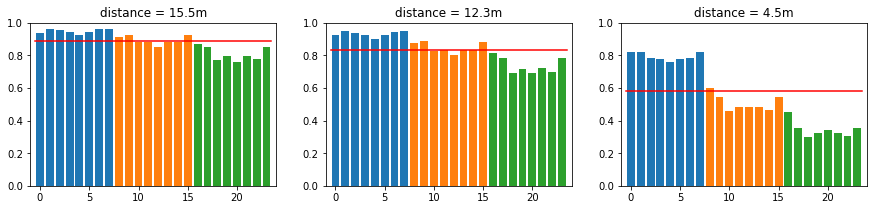

In [47]:
drt = ['S','SW','W','NW','N','NE','E','SE']

plt.figure(figsize= (15,3))

distance = [15.5, 12.3, 4.5]
expected = [0.89, 0.83, 0.58]

for fn in [1,2,3]:
    plt.subplot(1,3,fn)
    n = 0
    for c in [1,2,3]:
        x = []
        y = []
        for r in drt:
            x.append(n)
            y.append(get_distance_coefficient_degradation(distance[fn-1], 'Cooling', c, r))
            n = n + 1
        plt.bar(x,y)
    plt.plot( [ -0.5,23.5 ] , [ expected[fn-1], expected[fn-1] ], "r" )
    plt.axis([-1,24,0,1])
    plt.title("distance = " + str(distance[fn-1]) + "m")
plt.show()

### 4) 日射熱の利用における定義

| 立地  | 名称                 | 地域建蔽率(%) | 暖房期の隣棟遮蔽係数(%) |
| ----- | -------------------- | ------------- | ----------------------- |
| 立地1 | 郊外                 | 25.0          | 96.0                    |
| 立地2 | 密集していない都市部 | 35.0          | 88.0                    |
| 立地3 | 密集都市部           | 50.0          | 59.0                    |

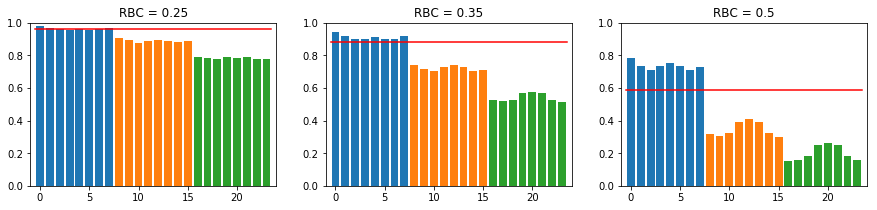

In [48]:
drt = ['S','SW','W','NW','N','NE','E','SE']

plt.figure(figsize= (15,3))

RBC = [0.25, 0.35, 0.5]
expected = [0.96, 0.88, 0.59]

for fn in [1,2,3]:
    plt.subplot(1,3,fn)
    n = 0
    for c in [1,2,3]:
        x = []
        y = []
        for r in drt:
            x.append(n)
            y.append(get_distance_coefficient_degradation(distance_rbc(RBC[fn-1]), 'Heating', c, r))
            n = n + 1
        plt.bar(x,y)
    plt.plot( [ -0.5,23.5 ] , [ expected[fn-1], expected[fn-1] ], "r" )
    plt.axis([-1,24,0,1])
    plt.title("RBC = " + str(RBC[fn-1]) )
plt.show()

## 区域建蔽率(地域建蔽率)について(仕様)

立地（郊外＝'kougai',密集していない都市部＝'toshibu',密集している都市部＝'misshu_toshibu'）に応じて、25%,35%,50%とする。

| 立地  | 名称                 | 地域建蔽率(%) |
| ----- | -------------------- | ------------- |
| 立地1 | 郊外                 | 25.0          |
| 立地2 | 密集していない都市部 | 35.0          |
| 立地3 | 密集都市部           | 50.0          |

In [49]:
def getRBC(ricchi):
    # ricchi: 立地
        # kougai: 郊外
        # toshibu: 密集していない都市部
        # misshu_toshibu: 密集している都市部
    if ricchi == 'kougai':
        return 0.25
    elif ricchi == 'toshibu':
        return 0.35
    elif ricchi == 'misshu_toshibu':
        return 0.5
    else:
        raise("error: ricchi")